<a href="https://colab.research.google.com/github/MMillward2012/deepmind_internship/blob/main/notebooks/2_train_finbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📦 Imports
We import the necessary packages for data manipulation, visualisation, model inference, and evaluation.

In [ ]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 📄 Load the Dataset

We load the dataset containing text and sentiment labels. The encoding is specified to handle special characters. Column names are explicitly set.

In [34]:
# Load CSV with column names: 'Sentiment' and 'Text'
data = pd.read_csv('data/FinancialAuditor/train_updated.csv', 
                   encoding='unicode_escape',
                   names=['Sentiment', 'Text'])

# Display the dataset shape and preview the first few rows
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (3878, 2)


,Sentiment,Text
0,Sentiment,Text
1,positive,Altia 's operating profit jumped to EUR 47 mil...
2,positive,The agreement was signed with Biohit Healthcar...
3,positive,"Kesko pursues a strategy of healthy , focused ..."
4,neutral,"Vaisala , headquartered in Helsinki in Finland..."


# 🧹 Preprocess Data

We extract the text and sentiment labels into separate lists for further processing.

In [27]:
X = data['Text'].to_list()
y = data['Sentiment'].to_list()

# 🤗 Load FinBERT Model

We load the FinBERT model and tokenizer from Hugging Face’s model hub. This model is pre-trained specifically on financial sentiment analysis.

In [ ]:
# Load tokenizer and sentiment classification model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# 🔮 Run Inference

We loop through each sentence, tokenise it, and run it through the FinBERT model to obtain predictions and their probabilities

In [ ]:
preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
for x in X:
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs) # Tokenize the input text
        logits = model(**input_sequence).logits # Raw output scores from the model
        scores = {
        k: v
        for k, v in zip(
            model.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()), # Convert logits to probabilities
        )
    }
    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

# 🧪 Evaluate Performance

We compute and display the model’s accuracy and a detailed classification report.

In [35]:
# Print overall accuracy
print(f"✅ Accuracy Score: {accuracy_score(y, preds):.4f}")

# Show precision, recall, and F1-score for each class
print("\n📋 Classification Report:\n")
print(classification_report(y, preds))

✅ Accuracy Score: 0.8889

📋 Classification Report:

              precision    recall  f1-score   support

   Sentiment       0.00      0.00      0.00         1
    negative       0.80      0.97      0.88       480
     neutral       0.96      0.86      0.91      2320
    positive       0.81      0.92      0.86      1077

    accuracy                           0.89      3878
   macro avg       0.64      0.69      0.66      3878
weighted avg       0.90      0.89      0.89      3878



/Users/matthew/Documents/deepmind_internship/venv-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/matthew/Documents/deepmind_internship/venv-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/matthew/Documents/deepmind_internship/venv-py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

# 📊 Visualise Confusion Matrix

We plot a confusion matrix to show how well the model distinguishes between sentiment classes.

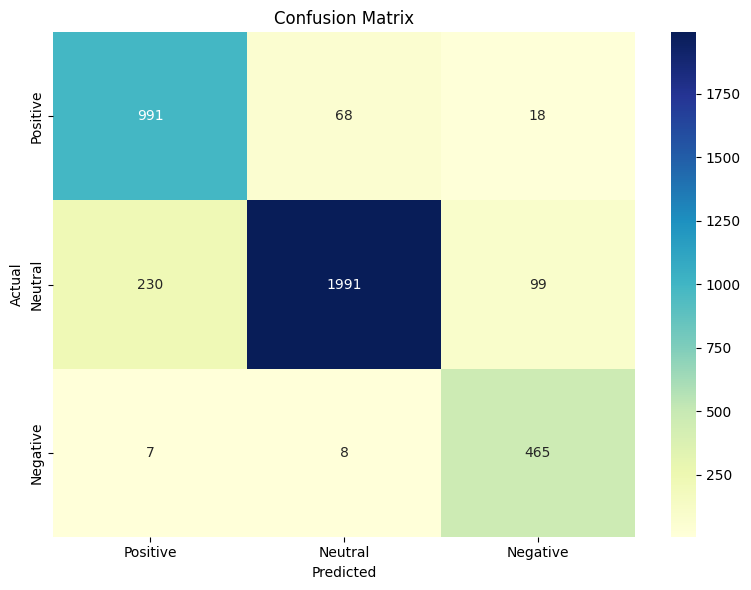

In [36]:
# Compute confusion matrix and convert to DataFrame for better labels
cm = confusion_matrix(y, preds, labels=['positive', 'neutral', 'negative'])
cm_df = pd.DataFrame(cm, index=['Positive', 'Neutral', 'Negative'], columns=['Positive', 'Neutral', 'Negative'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
